In [1]:
import os
import uuid
from pathlib import Path

from dotenv import load_dotenv

from azureml.core import Environment, Model, Workspace
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice

load_dotenv()
AZURE_SUBSCRIPTION_ID = os.getenv("AZURE_SUBSCRIPTION_ID")
AZURE_RESOURCE_GROUP = os.getenv("AZURE_RESOURCE_GROUP")
AZURE_WORKSPACE_NAME = os.getenv("AZURE_WORKSPACE_NAME")


In [2]:
version = str(uuid.uuid4())[:4]

source_directory = "./azureml"
experiment_name = "oc-p8-experiment-1"
model_name = "deeplab_v3plus_128_augment"


# connect to your workspace
ws = Workspace(
    subscription_id=AZURE_SUBSCRIPTION_ID,
    resource_group=AZURE_RESOURCE_GROUP,
    workspace_name=AZURE_WORKSPACE_NAME,
)


env_name = experiment_name + "-predict"
try:
    env = Environment.get(workspace=ws, name=env_name)
except:
    env = Environment.from_conda_specification(
        name=env_name,
        file_path=Path(source_directory, "conda_dependencies.yml"),
    )
    env.inferencing_stack_version = "latest"
    env.register(workspace=ws)


inference_config = InferenceConfig(
    source_directory=source_directory,
    entry_script="predict.py",
    environment=env,
)


aci_config = AciWebservice.deploy_configuration(
    cpu_cores=1,
    memory_gb=2,
    auth_enabled=True,
)

model = Model(ws, model_name)


service = Model.deploy(
    workspace=ws,
    name=model_name.replace("_", "-") + "-" + version,
    models=[model],
    inference_config=inference_config,
    deployment_config=aci_config,
    overwrite=True,
)

service.wait_for_deployment(show_output=True)


Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-03-08 12:24:24+01:00 Creating Container Registry if not exists.
2022-03-08 12:24:24+01:00 Registering the environment.
2022-03-08 12:24:27+01:00 Use the existing image.
2022-03-08 12:24:27+01:00 Generating deployment configuration.
2022-03-08 12:24:30+01:00 Submitting deployment to compute.
2022-03-08 12:24:35+01:00 Checking the status of deployment deeplab-v3plus-128-augment-2beb..
2022-03-08 12:26:51+01:00 Checking the status of inference endpoint deeplab-v3plus-128-augment-2beb.
Succeeded
ACI service creation operation finished, operation "Succeeded"


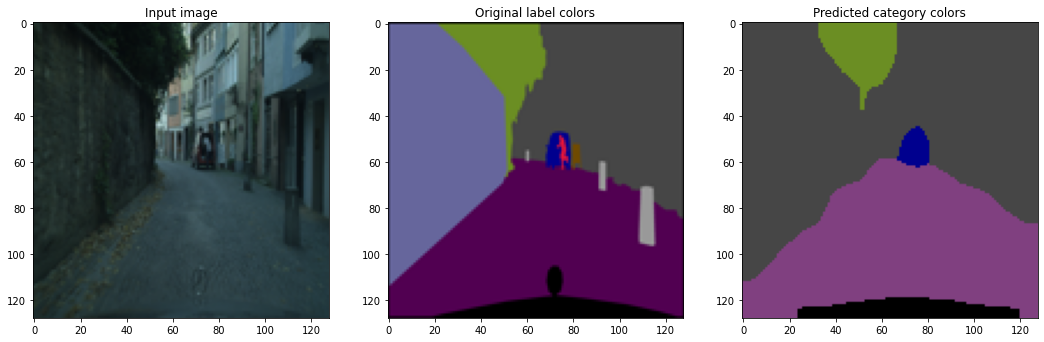

In [7]:
import base64
import json
import os
import ssl
import urllib.request
from io import BytesIO
from pathlib import Path

import numpy as np
from dotenv import load_dotenv
from matplotlib import pyplot as plt
from PIL import Image

from azureml.core import Model, Workspace

load_dotenv()
AZURE_SUBSCRIPTION_ID = os.getenv("AZURE_SUBSCRIPTION_ID")
AZURE_RESOURCE_GROUP = os.getenv("AZURE_RESOURCE_GROUP")
AZURE_WORKSPACE_NAME = os.getenv("AZURE_WORKSPACE_NAME")

AZURE_INFERENCE_KEY = os.getenv("AZURE_INFERENCE_KEY")


# Get the model
model_name = "deeplab_v3plus_128_augment"
resize = int(model_name.replace("_augment", "").split("_")[-1])
img_size = (resize, resize)

raw_data_path = Path("./../data/raw")
leftImg8bit_path = Path(raw_data_path, "leftImg8bit")
gtFine_path = Path(raw_data_path, "gtFine")

# Train dataset
train_input_img_paths = sorted(
    Path(leftImg8bit_path, "train").glob("**/*_leftImg8bit.png")
)
train_label_ids_img_paths = sorted(
    Path(gtFine_path, "train").glob("**/*_gtFine_labelIds.png")
)

# Validation dataset
val_input_img_paths = sorted(
    Path(leftImg8bit_path, "val").glob("**/*_leftImg8bit.png")
)
val_label_ids_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_gtFine_labelIds.png")
)
val_label_colors_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_color.png")
)


rand_idx = np.random.randint(0, len(val_input_img_paths))


def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if (
        allowed
        and not os.environ.get("PYTHONHTTPSVERIFY", "")
        and getattr(ssl, "_create_unverified_context", None)
    ):
        ssl._create_default_https_context = ssl._create_unverified_context


allowSelfSignedHttps(
    True
)  # this line is needed if you use self-signed certificate in your scoring service.

with open(val_input_img_paths[rand_idx], "rb") as f:
    im_read = f.read()
    im_b64 = base64.b64encode(im_read)
    im_b64_str = im_b64.decode("utf-8")

# Request data goes here
data = {"image": im_b64_str}


body = str.encode(json.dumps(data))

url = "http://a11c203b-8112-4724-99e9-2e933706e373.westeurope.azurecontainer.io/score"
headers = {
    "Content-Type": "application/json",
    "Authorization": ("Bearer " + AZURE_INFERENCE_KEY),
}

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()

except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(json.loads(error.read().decode("utf8", "ignore")))


fig, ax = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(18, 6),
)

ax[0].title.set_text("Input image")
val_img = Image.open(val_input_img_paths[rand_idx]).resize(img_size)
ax[0].imshow(val_img)

ax[1].title.set_text("Original label colors")
val_colors = Image.open(val_label_colors_img_paths[rand_idx]).resize(img_size)
ax[1].imshow(val_colors)

ax[2].title.set_text("Predicted category colors")
ax[2].imshow(Image.open(BytesIO(base64.b64decode(result))))

plt.show()
